# Import

In [1]:
import numpy as np
import pandas as pd
import os
import math
import random 

from scipy import stats #Analysis 
from scipy.stats import norm 

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [10]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
#from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 1. Data Load  

**치매 예방을 위한 라이프로그 치매 분류**

**9,327 rows × 2 columns x 5 picture**

For more details https://aihub.or.kr/problem_contest/nipa-learning-platform/6

In [4]:
# original data : data 
path = "./Dataset/pic_dataset"

FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=1

filenames = os.listdir(path)
categories = []
for filename in filenames:
    category = filename.split('_')[0]
    if category == 'CN':
        categories.append(0)
    elif  category == 'MCI':
        categories.append(1)
    else:
        categories.append(2)

data = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

data

,filename,category
0,CN_0.png,0
1,CN_1.png,0
2,CN_10.png,0
3,CN_1000.png,0
4,CN_1001.png,0
...,...,...
9324,MCI_95.png,1
9325,MCI_96.png,1
9326,MCI_97.png,1
9327,MCI_98.png,1


# 2. EDA  

**9,327 rows × 66 columns**

148명에 대한 데일리 라이프로그 데이터  
크게 **1. 기본 정보 2. 걸음거리 3.수면 4.컨버팅 데이터**로 나눌 수 있겠습니다. 

**4. converting**
- CONVERT(activity_class_5min USING utf8)    
- CONVERT(activity_met_1min USING utf8)      
- CONVERT(sleep_hr_5min USING utf8)          
- CONVERT(sleep_hypnogram_5min USING utf8)  
- CONVERT(sleep_rmssd_5min USING utf8) 

**y variable**
- DIAG_NM 
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9329 entries, 0 to 9328
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  9329 non-null   object
 1   category  9329 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 145.9+ KB


# 3. Preprocessing 

**9,327 rows × 2 columns × 5 pictures**

|**===================Default 하게 진행======================**

CNN 모델에서는 converting feature를 png로 변환한 데이터를 사용할 예정 (이와 관련하여 create_pic_dataset.ipynb 참고할 것!)

**feature processing**
- astype : float 
- sig1_data, sig2_data, sig3_data, sig4_data, sig5_data 
    - CONVERT(activity_class_5min USING utf8)    
    - CONVERT(activity_met_1min USING utf8)      
    - CONVERT(sleep_hr_5min USING utf8)          
    - CONVERT(sleep_hypnogram_5min USING utf8)  
    - CONVERT(sleep_rmssd_5min USING utf8) 

**=========================Y Varible=========================**

- DIAG_NM 
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)
    - Lable Encoding 

In [6]:
# data를 따로 관리합니다 
# original data -> data 
# preprocessing data -> processed_data
processed_data = data.copy()

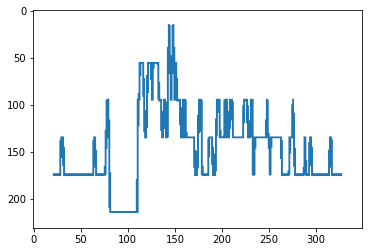

In [13]:
sample = random.choice(filenames)
image = tf.keras.preprocessing.image.load_img (path+"/"+sample)
plt.imshow(image)

# 4. Data Split + y Variable Processing 

모든 전처리와 y variable labeling이 완료되었다.  
train / valid / test data로 분할하고 용도에 맞게 model을 돌리도록 하자.

- **3d - array 처리** 
    - Sequential model 의 input layer에는 ndarray 데이터만 들어가야 함
- **y 변수 두 가지로 encoding** 
    - Label Encoding (le) -> sparse_categorical_crossentropy 실험 
    - One Hot Encoding (ohe) -> categorical_crossentropy 실험 
- **train / test** 
    - Sequential model option 중 validation dataset을 자동으로 나눠주는 것이 존재 하므로 


- 즉 다음과 같은 조합이 하나의 dataset 이며  
    - input_data_X1 + input_data_y_le + input_data_y_ohe
    - 실험은 한 모델당 두 가지 y 변수로 2번 실험하면 됨
    - **inpu_data_X1_le + input_data_y_le**
    - **inpu_data_X1_ohe + input_data_y_ohe**

# 5. Modeling - DL 

- **simple RNN** 
    - ohe **0.638**
    - le **0.639**
- **multi-layer RNN**
    - ohe 0.637
    - le 0.637
- **simple LSTM**
    - ohe 
    - le 
- **multi-layer LSTM**
    - ohe 
    - le 

In [437]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_113 (Conv2D)         (None, 126, 126, 32)      320       
                                                                 
 batch_normalization_78 (Bat  (None, 126, 126, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_116 (MaxPooli  (None, 63, 63, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_123 (Dropout)       (None, 63, 63, 32)        0         
                                                                 
 conv2d_114 (Conv2D)         (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_79 (Bat  (None, 61, 61, 64)     

In [438]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, 3, activation='relu', padding="same", input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(48, 3, activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, 3, activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, 3, activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='sigmoid')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_116 (Conv2D)         (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_119 (MaxPooli  (None, 64, 64, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_117 (Conv2D)         (None, 64, 64, 48)        13872     
                                                                 
 max_pooling2d_120 (MaxPooli  (None, 32, 32, 48)       0         
 ng2D)                                                           
                                                                 
 dropout_127 (Dropout)       (None, 32, 32, 48)        0         
                                                                 
 conv2d_118 (Conv2D)         (None, 32, 32, 64)      

In [440]:
earlystop = EarlyStopping(patience=10)

In [441]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [442]:
callbacks = [earlystop, learning_rate_reduction]

In [443]:
df["category"] = df["category"].replace({0: 'CN', 1: 'MCI', 2: 'Dem'}) 

In [444]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [447]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [448]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "C:/Users/okchr/mechine_learning/inputG", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
)

Found 7462 validated image filenames belonging to 3 classes.


In [449]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "C:/Users/okchr/mechine_learning/inputG", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size
)

Found 1865 validated image filenames belonging to 3 classes.


C:\Users\okchr\anaconda3\lib\site-packages\keras\preprocessing\image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [450]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "C:/Users/okchr/mechine_learning/inputG", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
)

Found 1 validated image filenames belonging to 1 classes.


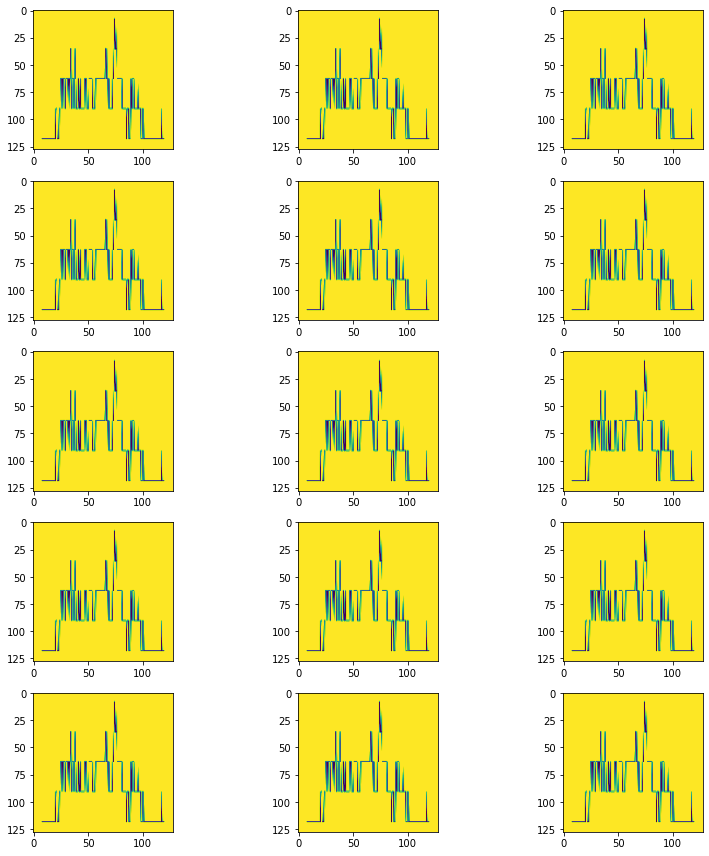

In [451]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [452]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50


C:\Users\okchr\AppData\Local\Temp/ipykernel_1112/612699584.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


497/497 [==============================] - 161s 323ms/step - loss: 0.8567 - accuracy: 0.6404 - val_loss: 0.8407 - val_accuracy: 0.6323 - lr: 0.0010
Epoch 2/50
497/497 [==============================] - 137s 276ms/step - loss: 0.8370 - accuracy: 0.6421 - val_loss: 0.8874 - val_accuracy: 0.6317 - lr: 0.0010
Epoch 3/50
497/497 [==============================] - 137s 276ms/step - loss: 0.8353 - accuracy: 0.6419 - val_loss: 0.8389 - val_accuracy: 0.6323 - lr: 0.0010
Epoch 4/50
497/497 [==============================] - 138s 277ms/step - loss: 0.8310 - accuracy: 0.6421 - val_loss: 0.8159 - val_accuracy: 0.6317 - lr: 0.0010
Epoch 5/50
497/497 [==============================] - 139s 280ms/step - loss: 0.8154 - accuracy: 0.6409 - val_loss: 0.8595 - val_accuracy: 0.6323 - lr: 0.0010
Epoch 6/50
497/497 [==============================] - 139s 280ms/step - loss: 0.8088 - accuracy: 0.6431 - val_loss: 0.7923 - val_accuracy: 0.6306 - lr: 0.0010
Epoch 7/50
497/497 [==============================] - 139

In [ ]:
model.save_weights("C:/Users/okchr/mechine_learning/model.h5")

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
test_filenames = os.listdir("../input/test1/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]